# Лабораторная работа №4
## Аппроксимации граничных условий второго рода в методе конечных разностей на примере уравнения теплопроводности
### Вариант 19
*Задание.* Найти приближенное решение начально-краевой задачи для уравнения теплопроводности:

$$
\begin{equation}
  \begin{cases}
    \frac{\partial u}{dt}=k\frac{\partial^2u}{\partial x^2}+f(x,t),  a < x < b, 0 < t \le T \\
    u(a, t) = g_1(t), \frac{\partial u}{\partial x}(b,t) = g_2(t),  0 < t \le T,\\
    u(x, 0) = \varphi(x), a \le x \le b.
  \end{cases}
\end{equation}
$$

используя явную и неявную разностные схемы.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# initial data variant 19

a = 0
b = 1
k = 0.2
T = 0.2
phi = lambda x: 1 - x*x
g1 = lambda t: 1
g2 = lambda t: 0
f = lambda x, t: 0
h = 0.01
t = 0.5 * h * h / k

NK = int((b - a) / h) + 1 
NT = int(T / t) + 1

### Явная схема

*Левая разность*

Используем аппроксимацию производной:
$$
\frac{\partial u}{\partial x} =\frac{u(x_n, \tau_N) - u(x_{n-1}, \tau_N)}{h} 
$$
Тогда: 
$$
g_2(\tau_N)=\frac{u(x_n, \tau_N) - u(x_{n-1}, \tau_N)}{h} 
$$
И
$$
u(x_n, \tau_N)=u(x_{n-1}, \tau_N)+hg_2(\tau_N)
$$

*Центральная разность*
$$
\frac{\partial u}{\partial x} =\frac{u(x_{n+1}, \tau_N) - u(x_{n-1}, \tau_N)}{2h} 
$$
Тогда: 
$$
g_2(\tau_N)=\frac{u(x_{n+1}, \tau_N) - u(x_{n-1}, \tau_N)}{2h} 
$$
И
$$
u(x_{n+1}, \tau_N)=u(x_{n-1}, \tau_N)+2hg_2(\tau_N)
$$


In [8]:
# left diffrence

def solve1l():
    M = np.zeros(shape=(NT, NK))
    M[:, 0] = np.array([g1(i) for i in np.linspace(0, T, NT)])
    M[0, :] = np.array([phi(i) for i in np.linspace(a, b, NK)])
    
    for i in range(1, NT):
        for j in range(1, NK - 1):
            xj = a + j*h
            M[i][j] = k * M[i-1][j+1]*t/(h*h) + \
                      (1 - 2*k*t/(h*h)) * M[i-1][j] + \
                      k*M[i-1][j-1]*t/(h*h) + \
                      t*f(xj, i*t)
        M[i][-1] = M[i][-2] + h * g2(t * i)
    return M

In [9]:
# central diffrence

def solve1c():
    M = np.zeros(shape=(NT, NK))
    M[:, 0] = np.array([g1(i) for i in np.linspace(0, T, NT)])
    M[0, :] = np.array([phi(i) for i in np.linspace(a, b, NK)])
    
    for i in range(1, NT):
        for j in range(1, NK - 1):
            xj = a + j*h
            M[i][j] = k * M[i-1][j+1]*t/(h*h) + \
                      (1 - 2*k*t/(h*h)) * M[i-1][j] + \
                      k*M[i-1][j-1]*t/(h*h) + \
                      t*f(xj, i*t)
        M[i][-1] = M[i][-3] + 2 * h * g2(t * i)
    return M

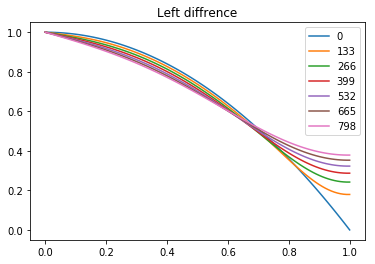

In [13]:
matrix = solve1l()
X = np.linspace(a, b, NK)

for i in range(0, NT, NT//6):
    plt.plot(X, matrix[i], label=i)
    plt.title("Left diffrence")
plt.legend()
plt.show()

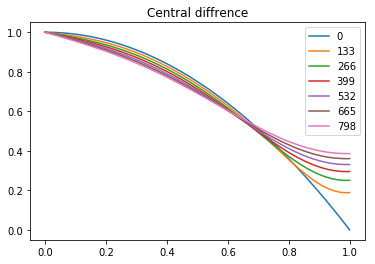

In [14]:
matrix = solve1c()
X = np.linspace(a, b, NK)

for i in range(0, NT, NT//6):
    plt.plot(X, matrix[i], label=i)
    plt.title("Central diffrence")
plt.legend()
plt.show()

### Неявная схема

Шаблон неявной схемы:
<img src="http://xreferat.com/image/54/1306483972_53.png" width="200" height="200">

Запишем аппроксимацию уравнения теплопроводности для неявной схемы:

$$
 \frac{u(x, t + \tau) - u(x, t)}{\tau} = k\frac{u(x-h, t+\tau)-2u(x, t+\tau)+u(x+h, t+\tau)}{h^2} +f(x,t)
$$

В этой схеме $u(x-h, t+\tau), u(x, t+\tau), u(x+h, t+\tau)$ - неизвестные значения. Соберем слева все неизвестные, а справа известные значения:

$$
\frac{ k\tau}{h^2}u(x-h,t+\tau)-(1+\frac{2k \tau}{h^2})u(x,t+\tau)+\frac{k\tau}{h^2}u(x+h,t+\tau)=-(u(x,t)+\tau f(x,t))
$$

Переобозначим коэффициенты при неизвестных:

$$
A_iu(x-h,t+\tau)-B_iu(x,t+\tau)+C_iu(x+h,t+\tau)=D_i
$$

Получили трехдиагональную систему линейных уравнений.

In [15]:
# left diffrence

def solve2l():
    M = np.zeros(shape=(NT, NK))
    M[:, 0] = np.array([g1(i) for i in np.linspace(0, T, NT)])
    M[0, :] = np.array([phi(i) for i in np.linspace(a, b, NK)])
    
    for i in range(1, NT):
        M2 = np.zeros(shape=(NK-1, NK-1))
        Y = np.zeros(NK-1)
        M2[0][0] = -(1 + 2 * k * t / (h*h))
        M2[0][1] = t * k / (h*h)
        Y[0] = -(M[i-1][1] + t*f(a + i*h, i*t) + k * t * M[i][0]/(h*h))
        
        for j in range(1, NK-2):
            M2[j][j-1] = k * t/(h*h)
            M2[j][j] = -(1 + 2 * k * t/(h*h))
            M2[j][j+1] = k * t/(h*h)
            Y[j] = -(M[i-1][j+1] + t*f(a + j*h, i*t))
        # last equation is approximation from even scheme
        M2[-1][-1] = -1
        M2[-1][-2] = 1
        Y[-1] = h * g2(t * i)
        
        M[i, 1:] = np.linalg.solve(M2, Y)
    return M

In [17]:
# central diffrence

def solve2c():
    M = np.zeros(shape=(NT, NK))
    M[:, 0] = np.array([g1(i) for i in np.linspace(0, T, NT)])
    M[0, :] = np.array([phi(i) for i in np.linspace(a, b, NK)])
    
    for i in range(1, NT):
        M2 = np.zeros(shape=(NK-1, NK-1))
        Y = np.zeros(NK-1)
        M2[0][0] = -(1 + 2 * k * t / (h*h))
        M2[0][1] = t * k / (h*h)
        Y[0] = -(M[i-1][1] + t*f(a + i*h, i*t) + k * t * M[i][0]/(h*h))
        
        for j in range(1, NK-2):
            M2[j][j-1] = k * t/(h*h)
            M2[j][j] = -(1 + 2 * k * t/(h*h))
            M2[j][j+1] = k * t/(h*h)
            Y[j] = -(M[i-1][j+1] + t*f(a + j*h, i*t))
        # last equation is approximation from even scheme
        M2[-1][-1] = -1
        M2[-1][-3] = 1
        Y[-1] = 2 * h * g2(t * i)
        
        M[i, 1:] = np.linalg.solve(M2, Y)
    return M

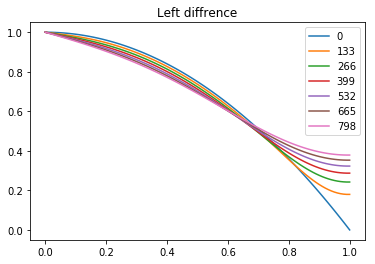

In [18]:
matrix = solve2l()
X = np.linspace(a, b, NK)

for i in range(0, NT, NT//6):
    plt.plot(X, matrix[i], label=i)
    plt.title("Left diffrence")
plt.legend()
plt.show()

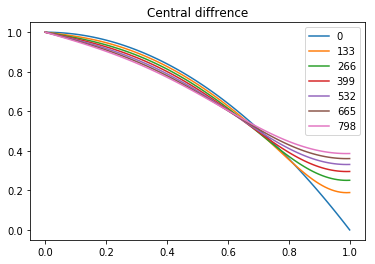

In [19]:
matrix = solve2c()
X = np.linspace(a, b, NK)

for i in range(0, NT, NT//6):
    plt.plot(X, matrix[i], label=i)
    plt.title("Central diffrence")
plt.legend()
plt.show()